# COVID-19 - Comparison of its evolution in different countries
### This comparison takes into account the population of a country and the starting date of deaths. 
Each curve represents the number of deaths as a percentage of the whole population in a country. The starting point is the date where the percentage is greater than 0.0001% (10 per million). 

## Get the input data

### Select the countries to process

In [1]:
country_list = ['France', 'Italy', 'US', 'Spain', 'Sweden']

### Select the minimal count of deaths for the starting date 

In [20]:
min_count = 0.0001 # percentage for 10 per million

### Choose Data tools

In [3]:
import pandas as pnd

### Import Country Reference Data

In [51]:
src_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19"
csv_ref_file = src_url + "/1a68338bddea934490f772051121adad47bf543e/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
ref_filter_column = 'Country_Region'
ref_data = pnd.read_csv(csv_ref_file)
ref_data = ref_data[ref_data[ref_filter_column].isin(country_list)]
ref_data = ref_data[ref_data['Province_State'].isnull()]
ref_data[['Country_Region','Population']].head()

,Country_Region,Population
58,France,65273512.0
81,Italy,60461828.0
153,Spain,46754783.0
157,Sweden,10099270.0
265,US,329466283.0


### Import Daily Covid-19 Data

In [69]:
csv_daily_file = src_url + "/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
filter_column = 'Country/Region'
drop_columns = ['Province/State', 'Lat', 'Long']
data_in = pnd.read_csv(csv_daily_file)
data_less_columns = data_in.drop(drop_columns, axis=1)    
data_less_rows = data_less_columns[data_less_columns[filter_column].isin(country_list)]
data_aggregated = data_less_rows.groupby(filter_column).sum() 
data = data_aggregated.reset_index()
data.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,France,0,0,0,0,0,0,0,0,0,...,3532,4043,5398,6520,7574,8093,8926,10343,10887,12228
1,Italy,0,0,0,0,0,0,0,0,0,...,12428,13155,13915,14681,15362,15887,16523,17127,17669,18279
2,Spain,0,0,0,0,0,0,0,0,0,...,8464,9387,10348,11198,11947,12641,13341,14045,14792,15447
3,Sweden,0,0,0,0,0,0,0,0,0,...,180,239,308,358,373,401,477,591,687,793
4,US,0,0,0,0,0,0,0,0,0,...,3873,4757,5926,7087,8407,9619,10783,12722,14695,16478


This original dataset organized as a table with timeseries as columns and 1 row per location (country, region, province). 
### Transform Input Data
It's easier to process this data with a different layout with 3 columns for each row of the new table: 1 column for the country, 1 for the date and 1 for the daily count as a percentage of the population.
Two sets of data are generated: 
- "data per capita" is the classic graph that shows the number of deaths taking place on the real date
- "data percentage" is a graph that shows the number of deaths as a percentage of the population on a day count since the day where the number of deaths exceeded 10 per million. 

In [82]:
data_per_capita = pnd.DataFrame()
data_percentage = pnd.DataFrame()
new_columns = ['country', 'date', 'nb_cases']
date_list = pnd.DataFrame(data_aggregated.columns)
# first_date=data.columns[1]
for filter_value in country_list:
    ref_data_single_row = ref_data[ref_data[ref_filter_column] == filter_value]
    population = ref_data_single_row['Population'].values[0]
    country_data = data[data[filter_column] == filter_value]
    y_values = country_data.values[0,1:]
    bool_count_started = False
    quantum = 0
    for date, value in zip(range(y_values.size), y_values):
        rel_value = value / population * 100
        if bool_count_started:
            quantum = date - start_date
        elif rel_value >= min_count:
            start_date = date 
            bool_count_started = True
        data_per_capita = data_per_capita.append({
            'country':filter_value,
            'date':date_list[0][date], 
            'nb_deaths':value
            }, ignore_index=True)
        data_percentage = data_percentage.append({
            'country':filter_value,
            'day':quantum, 
            'deaths %':rel_value
            }, ignore_index=True)
display(data_per_capita.tail(), data_percentage.tail())

,country,date,nb_deaths
390,Sweden,4/5/20,401.0
391,Sweden,4/6/20,477.0
392,Sweden,4/7/20,591.0
393,Sweden,4/8/20,687.0
394,Sweden,4/9/20,793.0


,country,day,deaths %
390,Sweden,17.0,0.003971
391,Sweden,18.0,0.004723
392,Sweden,19.0,0.005852
393,Sweden,20.0,0.006802
394,Sweden,21.0,0.007852


### Display the graph

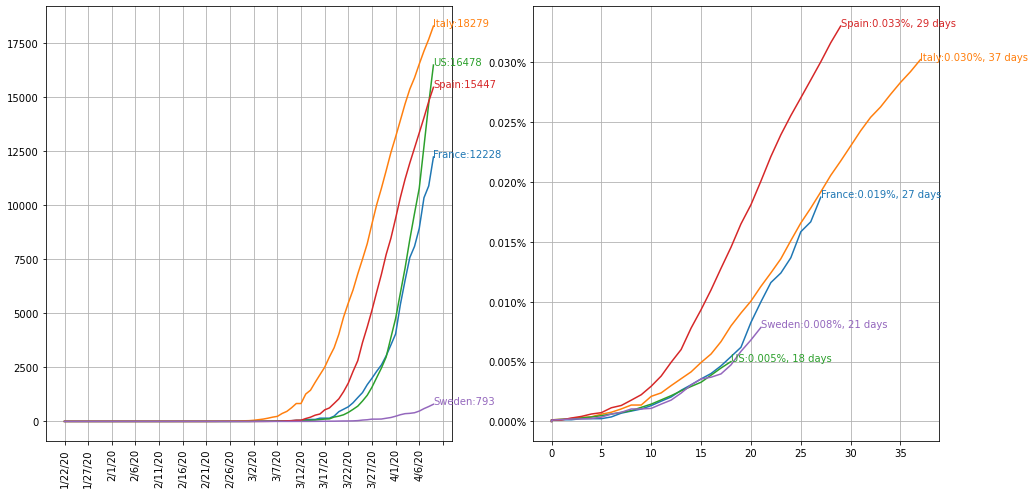

In [107]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
fig, (graph1, graph2) = plt.subplots(1, 2, figsize=(16,8))
ticker = tck.StrMethodFormatter('{x:,.3f}%')
graph2.yaxis.set_major_formatter(ticker) 
for country in country_list:
    graph_per_capita = graph1.plot(data_per_capita[data_per_capita['country'] == country]['date'], 
        data_per_capita[data_per_capita['country'] == country]['nb_deaths'], 
        label=country)
    last_x1, last_y1 = graph_per_capita[0].get_data()[0][-1], graph_per_capita[0].get_data()[1][-1]
    str_y1 = ':{:.0f}'.format(last_y1)
    graph1.annotate(xy=[last_x1, last_y1], s=country + str_y1, color=graph_per_capita[0].get_color())
    graph_percentage = graph2.plot(data_percentage[data_percentage['country'] == country]['day'], 
        data_percentage[data_percentage['country'] == country]['deaths %'], 
        label=country)
    last_x2, last_y2 = graph_percentage[0].get_data()[0][-1], graph_percentage[0].get_data()[1][-1]
    str2 = ':{:.3f}%, {:.0f} days'.format(last_y2, last_x2) 
    graph2.annotate(xy=[last_x2, last_y2], s=country + str2, color=graph_percentage[0].get_color())
graph1.grid()
graph1.xaxis.set_major_locator(tck.MaxNLocator(20))
graph1.tick_params('x', labelrotation=90)
graph2.grid()
plt.show()